# Week 4 Lab: Optimizing the Labeling Process

**CS 203: Software Tools and Techniques for AI**  
**IIT Gandhinagar**

---

## Learning Objectives

By the end of this lab, you will be able to:

1. Implement Active Learning with uncertainty sampling using modAL
2. Write and apply labeling functions for Weak Supervision with Snorkel
3. Use LLMs (like Gemini) to generate labels programmatically
4. Detect and handle noisy labels with cleanlab
5. Compare the cost and quality trade-offs of different labeling approaches

---

## Netflix Movie Theme

We need to label 100,000 movie reviews for sentiment analysis. Manual labeling would cost $30,000 and take months. Let's use smarter approaches!

---

## Part 1: Environment Setup

In [ ]:
# Install required packages
!pip install modAL-python scikit-learn pandas numpy matplotlib seaborn
!pip install snorkel
!pip install cleanlab
!pip install google-generativeai  # For Gemini API

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.1/306.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(42)
print("All imports successful!")

All imports successful!


---

## Part 2: Create Movie Review Dataset

In [ ]:
# Create synthetic movie review dataset
positive_templates = [
    "Amazing movie! Loved every minute of {movie}.",
    "{movie} was absolutely fantastic. A must-watch!",
    "Best film I've seen this year. {movie} is a masterpiece.",
    "Incredible performances in {movie}. Highly recommend!",
    "{movie} exceeded all my expectations. Perfect 10/10.",
    "Brilliant storytelling in {movie}. Oscar-worthy!",
    "Loved {movie}! The acting was superb.",
    "{movie} is a triumph. Beautifully crafted film.",
]

negative_templates = [
    "Terrible movie. {movie} was a complete waste of time.",
    "{movie} was awful. Avoid at all costs.",
    "Worst film I've ever seen. {movie} is garbage.",
    "{movie} was boring and predictable. Very disappointed.",
    "Don't waste your money on {movie}. Horrible!",
    "{movie} has no redeeming qualities. Truly bad.",
    "Painful to watch. {movie} is a disaster.",
    "{movie} is insulting to audiences. Just awful.",
]

neutral_templates = [
    "{movie} was okay. Nothing special.",
    "Average film. {movie} had its moments.",
    "{movie} is fine. Not great, not terrible.",
    "Meh. {movie} was just okay.",
    "{movie} was watchable but forgettable.",
    "It's alright. {movie} passes the time.",
]

movies = ['Inception', 'The Matrix', 'Avatar', 'Titanic', 'Interstellar',
          'The Godfather', 'Pulp Fiction', 'Parasite', 'Joker', 'Gladiator']

def generate_reviews(n_samples=1000):
    reviews = []
    labels = []

    for _ in range(n_samples):
        movie = np.random.choice(movies)
        sentiment = np.random.choice(['positive', 'negative', 'neutral'], p=[0.4, 0.4, 0.2])

        if sentiment == 'positive':
            template = np.random.choice(positive_templates)
            label = 1
        elif sentiment == 'negative':
            template = np.random.choice(negative_templates)
            label = 0
        else:
            template = np.random.choice(neutral_templates)
            label = 2  # We'll treat neutral as a separate class

        reviews.append(template.format(movie=movie))
        labels.append(label)

    return reviews, labels

# Generate dataset
reviews, labels = generate_reviews(n_samples=1000)
df = pd.DataFrame({'review': reviews, 'label': labels})

print(f"Generated {len(df)} reviews")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample reviews:")
df.head()

Generated 1000 reviews

Label distribution:
label
0    426
1    392
2    182
Name: count, dtype: int64

Sample reviews:


,review,label
0,Painful to watch. Pulp Fiction is a disaster.,0
1,Painful to watch. Parasite is a disaster.,0
2,Best film I've seen this year. Gladiator is a ...,1
3,Parasite is a triumph. Beautifully crafted film.,1
4,Don't waste your money on Parasite. Horrible!,0


In [ ]:
# Convert to binary classification (positive vs negative, drop neutral for simplicity)
df_binary = df[df['label'] != 2].copy()
print(f"Binary dataset size: {len(df_binary)}")

# Vectorize text
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(df_binary['review']).toarray()
y = df_binary['label'].values

# Split into train (unlabeled pool), validation, and test
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_val, y_pool, y_val = train_test_split(X_pool, y_pool, test_size=0.1, random_state=42)

print(f"Pool size: {len(X_pool)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Binary dataset size: 818
Pool size: 588
Validation size: 66
Test size: 164


---

## Part 3: Active Learning with modAL

### 3.1 The Active Learning Loop

In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

# Start with a small seed set (simulating initial labeled data)
n_initial = 20
initial_idx = np.random.choice(range(len(X_pool)), size=n_initial, replace=False)

X_initial = X_pool[initial_idx]
y_initial = y_pool[initial_idx]

# Remove initial samples from pool
mask = np.ones(len(X_pool), dtype=bool)
mask[initial_idx] = False
X_pool_remaining = X_pool[mask]
y_pool_remaining = y_pool[mask]

print(f"Initial labeled set: {len(X_initial)}")
print(f"Remaining pool: {len(X_pool_remaining)}")

Initial labeled set: 20
Remaining pool: 568


### Question 3.1 (Solved): Create Active Learner with Uncertainty Sampling

In [ ]:
# SOLVED: Create and train Active Learner

# Initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    query_strategy=uncertainty_sampling,
    X_training=X_initial,
    y_training=y_initial
)

# Check initial performance
initial_accuracy = learner.score(X_test, y_test)
print(f"Initial accuracy with {n_initial} samples: {initial_accuracy:.2%}")

Initial accuracy with 20 samples: 82.93%


### Question 3.2 (Solved): Run Active Learning Loop

In [ ]:
# SOLVED: Active Learning Loop

n_queries = 50  # Number of samples to query
performance_history = [initial_accuracy]

# Copy pool to work with
X_pool_al = X_pool_remaining.copy()
y_pool_al = y_pool_remaining.copy()

for i in range(n_queries):
    # Query for the most uncertain sample
    query_idx, query_instance = learner.query(X_pool_al)

    # Get the label (in practice, this would be a human annotator)
    y_new = y_pool_al[query_idx]

    # Teach the model
    learner.teach(X_pool_al[query_idx].reshape(1, -1), y_new.reshape(-1))

    # Remove queried sample from pool
    X_pool_al = np.delete(X_pool_al, query_idx, axis=0)
    y_pool_al = np.delete(y_pool_al, query_idx)

    # Track performance
    accuracy = learner.score(X_test, y_test)
    performance_history.append(accuracy)

    if (i + 1) % 10 == 0:
        print(f"Query {i+1}: Accuracy = {accuracy:.2%}")

print(f"\nFinal accuracy: {performance_history[-1]:.2%}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Query 10: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Query 20: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Query 30: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Query 40: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Query 50: Accuracy = 100.00%

Final accuracy: 100.00%


### Question 3.3: Compare with Random Sampling

In [ ]:
# TODO: Implement random sampling baseline and compare with active learning
# Create a learning curve comparing both approaches

def random_sampling(classifier, X_pool, n_instances=1):
    """Random query strategy for baseline comparison."""
    n_samples = X_pool.shape[0]
    query_idx = np.random.choice(
        range(n_samples),
        size=n_instances,
        replace=False
    )
    return query_idx, X_pool[query_idx]

# Run random sampling loop and collect performance

# Your code here
# 2️⃣ Initialize fresh learner (same initial data for fair comparison)
random_learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    query_strategy=random_sampling,
    X_training=X_initial,
    y_training=y_initial
)

# 3️⃣ Track performance
random_performance = [random_learner.score(X_test, y_test)]

# 4️⃣ Copy pool so original data is untouched
X_pool_rand = X_pool_remaining.copy()
y_pool_rand = y_pool_remaining.copy()

# 5️⃣ Run random sampling loop
for i in range(n_queries):

    # Query a random sample
    query_idx, query_instance = random_learner.query(X_pool_rand)

    # Get its true label (simulated annotation)
    y_new = y_pool_rand[query_idx]

    # Teach the model
    random_learner.teach(
        X_pool_rand[query_idx].reshape(1, -1),
        y_new.reshape(-1)
    )

    # Remove selected sample from pool
    X_pool_rand = np.delete(X_pool_rand, query_idx, axis=0)
    y_pool_rand = np.delete(y_pool_rand, query_idx)

    # Evaluate on test set
    accuracy = random_learner.score(X_test, y_test)
    random_performance.append(accuracy)

    # Print progress every 10 queries
    if (i + 1) % 10 == 0:
        print(f"Random Query {i+1}: Accuracy = {accuracy:.2%}")

print(f"\nFinal Random Sampling Accuracy: {random_performance[-1]:.2%}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Random Query 10: Accuracy = 92.68%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Random Query 20: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Random Query 30: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Random Query 40: Accuracy = 100.00%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Random Query 50: Accuracy = 100.00%

Final Random Sampling Accuracy: 100.00%


### Question 3.4: Plot Learning Curves

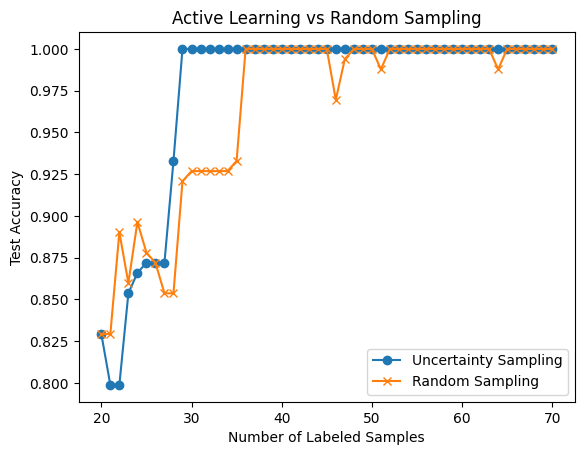

In [ ]:
# TODO: Plot learning curves for Active Learning vs Random Sampling
# X-axis: Number of labeled samples
# Y-axis: Test accuracy

# Your code here
import matplotlib.pyplot as plt
import numpy as np

labeled_samples = np.arange(
    n_initial,
    n_initial + n_queries + 1
)

plt.figure()

plt.plot(labeled_samples, performance_history, marker='o')
plt.plot(labeled_samples, random_performance, marker='x')

plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.title("Active Learning vs Random Sampling")

plt.legend(["Uncertainty Sampling", "Random Sampling"])

plt.show()


### Question 3.5: Try Different Query Strategies

Compare uncertainty sampling, margin sampling, and entropy sampling.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

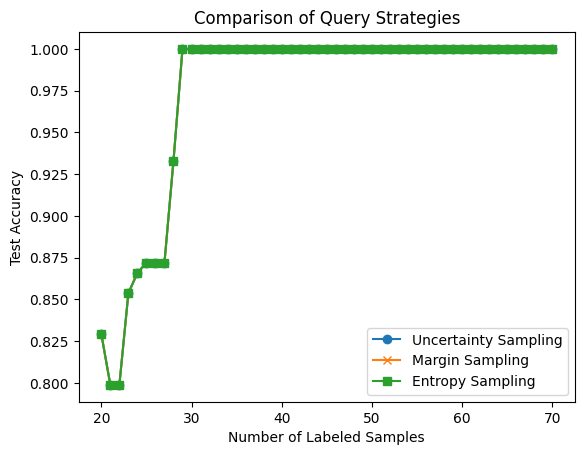

In [ ]:
# TODO: Compare different query strategies
# Run active learning with:
# 1. uncertainty_sampling
# 2. margin_sampling
# 3. entropy_sampling
# Plot all three on the same graph

# Your code here
import numpy as np
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling
from sklearn.ensemble import RandomForestClassifier


def run_active_learning(query_strategy):

    # Fresh learner (same initial data for fairness)
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        query_strategy=query_strategy,
        X_training=X_initial,
        y_training=y_initial
    )

    performance = [learner.score(X_test, y_test)]

    # Copy pool
    X_pool_temp = X_pool_remaining.copy()
    y_pool_temp = y_pool_remaining.copy()

    for _ in range(n_queries):

        # Query sample
        query_idx, query_instance = learner.query(X_pool_temp)

        # Get label
        y_new = y_pool_temp[query_idx]

        # Teach model
        learner.teach(
            X_pool_temp[query_idx].reshape(1, -1),
            y_new.reshape(-1)
        )

        # Remove from pool
        X_pool_temp = np.delete(X_pool_temp, query_idx, axis=0)
        y_pool_temp = np.delete(y_pool_temp, query_idx)

        # Track accuracy
        acc = learner.score(X_test, y_test)
        performance.append(acc)

    return performance


# Run all three strategies
performance_uncertainty = run_active_learning(uncertainty_sampling)
performance_margin = run_active_learning(margin_sampling)
performance_entropy = run_active_learning(entropy_sampling)


# X-axis: number of labeled samples
labeled_samples = np.arange(
    n_initial,
    n_initial + n_queries + 1
)

# Plot results
plt.figure()

plt.plot(labeled_samples, performance_uncertainty, marker='o')
plt.plot(labeled_samples, performance_margin, marker='x')
plt.plot(labeled_samples, performance_entropy, marker='s')

plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Query Strategies")

plt.legend([
    "Uncertainty Sampling",
    "Margin Sampling",
    "Entropy Sampling"
])

plt.show()


### Questio 3.6. Query by committee

"""
### Question 3.6 (Solved): Query by Committee (QBC)

Query by Committee is an alternative active learning strategy where multiple models
("committee members") vote on predictions. We query examples where the committee
disagrees the most.

**Key Idea:**
- Train multiple diverse models (e.g., Random Forest, Logistic Regression, SVM, Naive Bayes)
- For each unlabeled example, get predictions from all models
- Measure disagreement (vote entropy)
- Query examples with highest disagreement

**Why it works:** High disagreement = models are uncertain → informative to label!
"""

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import entropy
import numpy as np

def vote_entropy_sampling(committee, X_pool):
    """Query strategy based on vote entropy (committee disagreement)."""
    predictions = np.array([member.predict(X_pool) for member in committee])
    vote_entropy_scores = []

    for i in range(X_pool.shape[0]):
        votes = predictions[:, i]
        unique_votes, counts = np.unique(votes, return_counts=True)
        vote_distribution = counts / len(committee)
        vote_entropy_scores.append(entropy(vote_distribution))

    query_idx = np.argmax(vote_entropy_scores)
    return query_idx, X_pool[query_idx].reshape(1, -1)


# Initialize committee with 4 diverse models
committee = [
    RandomForestClassifier(n_estimators=50, random_state=42),
    LogisticRegression(max_iter=1000, random_state=42),
    SVC(kernel='linear', probability=True, random_state=42),
    MultinomialNB()
]

# Train committee on initial data
for member in committee:
    member.fit(X_initial, y_initial)

print("Committee initialized with 4 models")
print(f"Starting with {n_initial} labeled samples\n")

Committee initialized with 4 models
Starting with 20 labeled samples



In [ ]:
# Run QBC loop
n_queries_qbc = 50
qbc_performance_history = []

X_pool_qbc = X_pool_remaining.copy()
y_pool_qbc = y_pool_remaining.copy()

# Store training data properly
X_train_qbc = X_initial.copy()
y_train_qbc = y_initial.copy()

for i in range(n_queries_qbc):
    # Query most uncertain sample
    query_idx, _ = vote_entropy_sampling(committee, X_pool_qbc)
    y_new = y_pool_qbc[query_idx]

    # Add to training set
    X_train_qbc = np.vstack([X_train_qbc, X_pool_qbc[query_idx]])
    y_train_qbc = np.append(y_train_qbc, y_new)

    # Retrain all committee members
    for member in committee:
        member.fit(X_train_qbc, y_train_qbc)

    # Remove from pool
    X_pool_qbc = np.delete(X_pool_qbc, query_idx, axis=0)
    y_pool_qbc = np.delete(y_pool_qbc, query_idx)

    # Evaluate with majority vote
    predictions = np.array([member.predict(X_test) for member in committee])
    majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    accuracy = np.mean(majority_vote == y_test)
    qbc_performance_history.append(accuracy)

    if (i + 1) % 10 == 0:
        print(f"Iteration {i + 1}: Accuracy = {accuracy:.4f}")

print(f"\nFinal QBC accuracy: {qbc_performance_history[-1]:.4f}")

Iteration 10: Accuracy = 0.9329
Iteration 20: Accuracy = 1.0000
Iteration 30: Accuracy = 1.0000
Iteration 40: Accuracy = 1.0000
Iteration 50: Accuracy = 1.0000

Final QBC accuracy: 1.0000


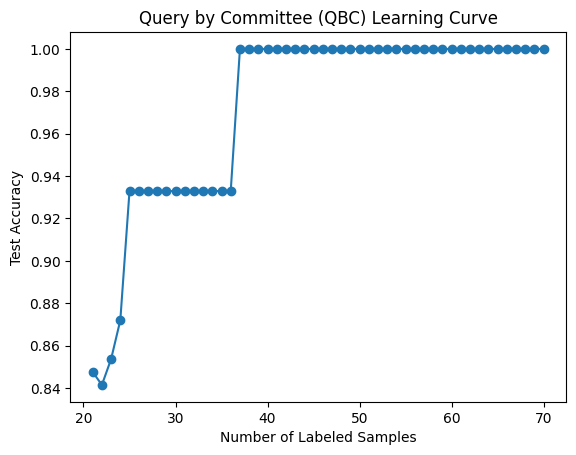

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: number of labeled samples
labeled_samples_qbc = np.arange(
    n_initial + 1,
    n_initial + n_queries_qbc + 1
)

plt.figure()

plt.plot(labeled_samples_qbc, qbc_performance_history, marker='o')

plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.title("Query by Committee (QBC) Learning Curve")

plt.show()


"""
### Question 3.7 (TODO): Experiment with QBC

Your tasks:

1. **Add a 5th model** - Try `GradientBoostingClassifier()` or `KNeighborsClassifier()`
2. **Compare committee sizes** - Run QBC with 2, 3, 4, and 5 members. Plot learning curves.
3. **Weighted voting** - Instead of majority vote, weight each member by validation accuracy
4. **KL divergence** (Advanced) - Replace vote entropy with KL divergence between predictions

"""

In [ ]:
# TODO Task 1: Add a 5th committee member
from sklearn.ensemble import GradientBoostingClassifier

# Your code here - create new committee with 5 members
# committee_5 = [...]


# TODO Task 2: Compare committee sizes
def run_qbc_experiment(committee_list, n_queries=30):
    """
    Run QBC and return performance history.

    Args:
        committee_list: List of classifiers
        n_queries: Number of queries to make

    Returns:
        performance_history: List of accuracies
    """
    # Your code here
    pass

# Test with different sizes
# performance_2 = run_qbc_experiment([model1, model2])
# performance_3 = run_qbc_experiment([model1, model2, model3])
# ... etc
# Plot all on same graph


# TODO Task 3: Weighted voting
def weighted_voting(committee, X, validation_accuracies):
    """
    Make predictions using weighted voting based on validation accuracy.

    Args:
        committee: List of models
        X: Data to predict
        validation_accuracies: List of weights (one per model)

    Returns:
        predictions: Weighted predictions
    """
    # Your code here
    # Hint: Each model's vote counts proportional to its accuracy
    pass


# TODO Task 4: KL Divergence (Advanced)
from scipy.stats import entropy

def kl_divergence_sampling(committee, X_pool):
    """
    Query based on average KL divergence from consensus.

    Args:
        committee: List of models with predict_proba
        X_pool: Unlabeled examples

    Returns:
        query_idx: Index of most informative sample
    """
    # Your code here
    # Hint:
    # 1. Get probability predictions from each member
    # 2. Calculate average (consensus) prediction
    # 3. Measure KL divergence of each member from consensus
    # 4. Query example with highest average KL divergence
    pass

---

## Part 4: Weak Supervision with Snorkel

### 4.1 Understanding Labeling Functions

In [ ]:
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel

# Constants for labels
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

# Prepare DataFrame for Snorkel
df_snorkel = df_binary.copy().reset_index(drop=True)
print(f"Dataset size: {len(df_snorkel)}")
df_snorkel.head()

Dataset size: 818


,review,label
0,Painful to watch. Pulp Fiction is a disaster.,0
1,Painful to watch. Parasite is a disaster.,0
2,Best film I've seen this year. Gladiator is a ...,1
3,Parasite is a triumph. Beautifully crafted film.,1
4,Don't waste your money on Parasite. Horrible!,0


### Question 4.1 (Solved): Write Labeling Functions

In [ ]:
# SOLVED: Labeling Functions for Sentiment Analysis

@labeling_function()
def lf_contains_amazing(x):
    """If review contains 'amazing', label as positive."""
    return POSITIVE if 'amazing' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_contains_terrible(x):
    """If review contains 'terrible', label as negative."""
    return NEGATIVE if 'terrible' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_contains_loved(x):
    """If review contains 'loved', label as positive."""
    return POSITIVE if 'loved' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_contains_awful(x):
    """If review contains 'awful', label as negative."""
    return NEGATIVE if 'awful' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_contains_masterpiece(x):
    """If review contains 'masterpiece', label as positive."""
    return POSITIVE if 'masterpiece' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_contains_waste(x):
    """If review contains 'waste', label as negative."""
    return NEGATIVE if 'waste' in x.review.lower() else ABSTAIN

@labeling_function()
def lf_exclamation_positive(x):
    """Multiple exclamations with positive words."""
    positive_words = ['great', 'amazing', 'love', 'best', 'fantastic']
    if x.review.count('!') >= 2:
        if any(word in x.review.lower() for word in positive_words):
            return POSITIVE
    return ABSTAIN

@labeling_function()
def lf_rating_positive(x):
    """If mentions high rating (9/10, 10/10), positive."""
    import re
    match = re.search(r'(9|10)/10', x.review)
    return POSITIVE if match else ABSTAIN

# Collect all LFs
lfs = [
    lf_contains_amazing, lf_contains_terrible, lf_contains_loved,
    lf_contains_awful, lf_contains_masterpiece, lf_contains_waste,
    lf_exclamation_positive, lf_rating_positive
]

print(f"Created {len(lfs)} labeling functions")

Created 8 labeling functions


### Question 4.2: Apply Labeling Functions

In [ ]:
# Apply LFs to data
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df_snorkel)

print(f"Label matrix shape: {L_train.shape}")
print(f"Labels: {L_train[:5]}")

100%|██████████| 818/818 [00:00<00:00, 21536.52it/s]

Label matrix shape: (818, 8)
Labels: [[-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  0 -1 -1]]


### Question 4.3 (Solved): Analyze Labeling Functions

In [ ]:
# SOLVED: Analyze LF performance
analysis = LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=df_snorkel['label'].values)
print("Labeling Function Analysis:")
analysis

Labeling Function Analysis:


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_contains_amazing,0,[1],0.055012,0.055012,0.0,45,0,1.0
lf_contains_terrible,1,[0],0.052567,0.052567,0.0,43,0,1.0
lf_contains_loved,2,[1],0.118582,0.055012,0.0,97,0,1.0
lf_contains_awful,3,[0],0.151589,0.000000,0.0,124,0,1.0
lf_contains_masterpiece,4,[1],0.046455,0.000000,0.0,38,0,1.0
lf_contains_waste,5,[0],0.118582,0.052567,0.0,97,0,1.0
lf_exclamation_positive,6,[],0.000000,0.000000,0.0,0,0,0.0
lf_rating_positive,7,[1],0.066015,0.000000,0.0,54,0,1.0


### Question 4.4: Train Label Model

In [ ]:
# TODO: Train the Label Model and get probabilistic labels

# Your code here
# Train the model
# Get predictions

# Initialize Label Model
label_model = LabelModel(cardinality=2, verbose=True)

# Train the model
label_model.fit(
    L_train=L_train,
    n_epochs=500,
    log_freq=100,
    seed=42
)

# Get probabilistic labels
probs_train = label_model.predict_proba(L=L_train)

# Get hard labels (most likely class)
preds_train = label_model.predict(L=L_train)

print("First 5 probabilistic labels:")
print(probs_train[:5])

print("\nFirst 5 predicted labels:")
print(preds_train[:5])

100%|██████████| 500/500 [00:00<00:00, 858.75epoch/s]

First 5 probabilistic labels:
[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.58640108 0.41359892]
 [0.5        0.5       ]
 [0.85297205 0.14702795]]

First 5 predicted labels:
[-1 -1  0 -1  0]


### Question 4.5: Write More Labeling Functions

Create 3 additional labeling functions to improve coverage.

In [ ]:
# TODO: Write 3 more labeling functions
# Consider: word patterns, punctuation, sentence structure

@labeling_function()
def lf_your_function_1(x):
    """Description"""
    # Your code here
    return ABSTAIN

@labeling_function()
def lf_your_function_2(x):
    """Description"""
    # Your code here
    return ABSTAIN

@labeling_function()
def lf_your_function_3(x):
    """Description"""
    # Your code here
    return ABSTAIN


### Question 4.6: Train Downstream Model with Weak Labels

In [ ]:
# TODO: Train a classifier using the probabilistic labels from the Label Model
# Compare performance with a model trained on true labels

# Your code here


---

## Part 5: LLM-Based Labeling

### 5.1 Setting Up Gemini API

Set your API key (get from https://makersuite.google.com/app/apikey)

#### if running in google colab

- add your key in google colab secrets panel (mention key name as GEMINI_API_KEY and paste your key in value field)
- provide access by clicking on the eye icon.
- then use the following code

```python
try:
    from google import genai
    client = genai.Client(api_key=os.environ.get('GEMINI_API_KEY', ''))
    print("Gemini client initialized!")
except Exception as e:
    print(f"Error: {e}")
    print("Set GEMINI_API_KEY environment variable to use LLM labeling")

```

In [ ]:
try:
    from google import genai
    client = genai.Client(api_key=os.environ.get('GEMINI_API_KEY', ''))
    print("Gemini client initialized!")
except Exception as e:
    print(f"Error: {e}")
    print("Set GEMINI_API_KEY environment variable to use LLM labeling")

#### if running locally

- Create a .env file in the same directory as your script and paste your key in the file (e.g. GEMINI_API_KEY="your_api_key")

```python
from dotenv import load_dotenv # !pip install python-dotenv
import os

load_dotenv()
key = os.getenv("GEMINI_API_KEY")
if key:
    print("Gemini client initialized!")
else:
    print("Set GEMINI_API_KEY environment variable to use LLM labeling")
```

### Question 5.1 (Solved): Create LLM Labeling Function

In [ ]:
# SOLVED: LLM Labeling Function (mock implementation for demo)

def label_with_llm(review, use_api=False):
    """
    Label a movie review using an LLM.

    Args:
        review: The review text
        use_api: If True, call actual API; else use mock

    Returns:
        dict with 'label' and 'confidence'
    """
    if use_api and 'GEMINI_API_KEY' in os.environ:
        prompt = f"""
        Classify the following movie review as POSITIVE or NEGATIVE.

        Review: "{review}"

        Respond with JSON format:
        {{"label": "POSITIVE" or "NEGATIVE", "confidence": 0.0-1.0}}
        """

        response = client.models.generate_content(
            model="gemini-2.0-flash-exp",
            contents=prompt
        )

        import json
        result = json.loads(response.text)
        return result
    else:
        # Mock implementation based on keywords
        positive_words = ['amazing', 'loved', 'fantastic', 'masterpiece', 'best', 'incredible']
        negative_words = ['terrible', 'awful', 'worst', 'waste', 'boring', 'disaster']

        review_lower = review.lower()
        pos_count = sum(1 for w in positive_words if w in review_lower)
        neg_count = sum(1 for w in negative_words if w in review_lower)

        if pos_count > neg_count:
            return {'label': 'POSITIVE', 'confidence': 0.8 + 0.1 * pos_count}
        elif neg_count > pos_count:
            return {'label': 'NEGATIVE', 'confidence': 0.8 + 0.1 * neg_count}
        else:
            return {'label': 'POSITIVE', 'confidence': 0.5}  # Default

# Test
test_review = "Amazing movie! Loved every minute of Inception."
result = label_with_llm(test_review)
print(f"Review: {test_review}")
print(f"Label: {result['label']}, Confidence: {result['confidence']:.2f}")

### Question 5.2: Batch Label with LLM

In [ ]:
# TODO: Label a batch of reviews using the LLM function
# Track time and estimated cost

sample_reviews = df_binary['review'].head(20).tolist()

# Your code here


### Question 5.3: Evaluate LLM Labels Against Ground Truth

In [ ]:
# TODO: Calculate accuracy, precision, recall of LLM labels
# Compare with human labels (ground truth)

# Your code here


### Question 5.4: Hybrid Labeling Strategy

In [ ]:
# TODO: Implement hybrid labeling
# - Use LLM for high-confidence labels
# - Send low-confidence examples to human review

def hybrid_labeling(reviews, confidence_threshold=0.8):
    """
    Label reviews using hybrid approach.

    Returns:
        llm_labeled: Reviews labeled by LLM
        human_queue: Reviews needing human review
    """
    # Your code here
    pass


---

## Part 6: Noisy Label Detection with cleanlab

### 6.1 Setting Up cleanlab

In [ ]:
from cleanlab import Datalab
from sklearn.model_selection import cross_val_predict

# Create a dataset with some noisy labels
X_noisy = X.copy()
y_noisy = y.copy()

# Flip 10% of labels to simulate noise
noise_idx = np.random.choice(len(y_noisy), size=int(0.1 * len(y_noisy)), replace=False)
y_noisy[noise_idx] = 1 - y_noisy[noise_idx]  # Flip labels

print(f"Added noise to {len(noise_idx)} labels ({len(noise_idx)/len(y_noisy):.1%})")

ModuleNotFoundError: No module named 'cleanlab'

### Question 6.1 (Solved): Find Label Issues

In [ ]:
# SOLVED: Use cleanlab to find label issues

# Get out-of-fold predictions
clf = LogisticRegression(max_iter=1000)
pred_probs = cross_val_predict(clf, X_noisy, y_noisy, cv=5, method='predict_proba')

# Create Datalab and find issues
data_dict = {
    'labels': y_noisy
}

lab = Datalab(data=data_dict, label_name='labels')
lab.find_issues(pred_probs=pred_probs)

# Get summary
print("Issue Summary:")
print(lab.get_issue_summary())

### Question 6.2: Analyze Detected Issues

In [ ]:
# Get detailed issues
issues = lab.get_issues()
print("\nLabel Issues:")
label_issues = issues[issues['is_label_issue'] == True]
print(f"Found {len(label_issues)} potential label errors")

# TODO: Calculate precision/recall of cleanlab's detection
# How many of the actual noisy labels did it find?
# How many false positives?

# Your code here


### Question 6.3: Train on Clean Data

In [ ]:
# TODO: Compare model performance:
# 1. Trained on all data (with noise)
# 2. Trained on clean data (removing detected issues)
# 3. Trained on true clean data (oracle)

# Your code here


---

## Part 7: Cost Comparison

### Question 7.1: Calculate Labeling Costs

In [ ]:
# Calculate and compare costs of different approaches

def calculate_costs(n_items, method):
    """
    Calculate estimated cost for different labeling methods.

    Args:
        n_items: Number of items to label
        method: 'manual', 'active_learning', 'weak_supervision', 'llm', 'hybrid'

    Returns:
        dict with cost, time, quality estimates
    """
    costs = {
        'manual': {
            'cost_per_item': 0.30,  # USD
            'time_per_item': 0.1,   # minutes
            'quality': 0.95,        # accuracy
            'items_needed': n_items
        },
        'active_learning': {
            'cost_per_item': 0.30,
            'time_per_item': 0.1,
            'quality': 0.90,
            'items_needed': n_items // 3  # 3x reduction
        },
        'weak_supervision': {
            'cost_per_item': 0.0,   # Just engineer time
            'setup_cost': 500,      # Writing LFs
            'time_per_item': 0.0,
            'quality': 0.80,
            'items_needed': 0
        },
        'llm': {
            'cost_per_item': 0.002,  # API cost
            'time_per_item': 0.01,   # minutes
            'quality': 0.85,
            'items_needed': n_items
        },
        'hybrid': {
            'cost_per_item': 0.05,  # Average
            'time_per_item': 0.02,
            'quality': 0.90,
            'items_needed': n_items
        }
    }

    method_info = costs[method]
    total_cost = method_info['cost_per_item'] * method_info['items_needed']
    if 'setup_cost' in method_info:
        total_cost += method_info['setup_cost']
    total_time = method_info['time_per_item'] * method_info['items_needed']

    return {
        'method': method,
        'total_cost': total_cost,
        'total_time_hours': total_time / 60,
        'expected_quality': method_info['quality']
    }

# Compare all methods for 100,000 items
n_items = 100000
methods = ['manual', 'active_learning', 'weak_supervision', 'llm', 'hybrid']

print(f"Cost comparison for {n_items:,} items:\n")
print(f"{'Method':<20} {'Cost ($)':<12} {'Time (hrs)':<12} {'Quality':<10}")
print("-" * 54)

for method in methods:
    result = calculate_costs(n_items, method)
    print(f"{result['method']:<20} ${result['total_cost']:>10,.2f} {result['total_time_hours']:>10,.1f} {result['expected_quality']:>8.0%}")

Cost comparison for 100,000 items:

Method               Cost ($)     Time (hrs)   Quality   
------------------------------------------------------
manual               $ 30,000.00      166.7      95%
active_learning      $  9,999.90       55.6      90%
weak_supervision     $    500.00        0.0      80%
llm                  $    200.00       16.7      85%
hybrid               $  5,000.00       33.3      90%


---

## Challenge Problems

### Challenge 1: Batch Active Learning

In [ ]:
# Challenge: Implement batch active learning with diversity
# Query 10 samples at a time, ensuring diversity using clustering

from sklearn.cluster import KMeans

def diversity_uncertainty_sampling(classifier, X_pool, n_instances=10):
    """
    Select n_instances that are both uncertain AND diverse.

    Strategy:
    1. Get uncertainty scores for all samples
    2. Cluster samples into n_instances clusters
    3. Pick most uncertain sample from each cluster
    """
    # Your code here
    pass


### Challenge 2: Combine All Methods

In [ ]:
# Challenge: Build a complete labeling pipeline that:
# 1. Uses weak supervision for initial bulk labels
# 2. Uses LLM to label uncertain examples
# 3. Uses active learning for remaining hard cases
# 4. Uses cleanlab to detect and fix errors

class SmartLabelingPipeline:
    def __init__(self, labeling_functions, llm_client=None, confidence_threshold=0.8):
        self.lfs = labeling_functions
        self.llm_client = llm_client
        self.threshold = confidence_threshold

    def label(self, data):
        """
        Label data using the hybrid pipeline.

        Returns:
            labels: Final labels
            sources: Source of each label (weak/llm/human)
            confidence: Confidence scores
        """
        # Your code here
        pass


### Challenge 3: Active Learning with Human-in-the-Loop UI

In [ ]:
# Challenge: Create an interactive labeling interface
# Use ipywidgets to create a simple annotation UI

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    # Create interactive labeling widget
    # Your code here

except ImportError:
    print("Install ipywidgets for interactive labeling: pip install ipywidgets")


---

## Summary

In this lab, you learned:

1. **Active Learning**: Query strategies (uncertainty, margin, entropy) to label smarter
2. **Weak Supervision**: Writing labeling functions to generate noisy but cheap labels
3. **LLM Labeling**: Using GPT/Gemini as automated annotators
4. **Noisy Label Detection**: Using cleanlab to find and fix label errors
5. **Cost Comparison**: Trade-offs between different labeling approaches

### Key Takeaways

| Method | Best When | Typical Savings |
|--------|-----------|----------------|
| Active Learning | Limited budget | 2-10x |
| Weak Supervision | Patterns exist | 10-100x |
| LLM Labeling | Well-defined task | 10-50x |
| Hybrid | Large scale projects | 5-20x |

### Next Week

Week 5: Data Augmentation - Create more training data without any labeling!